In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [5]:
df = pd.DataFrame(list(map(json.loads, tqdm(open("howpop_full.jsonlines")))))

138127it [01:53, 1212.19it/s]


In [3]:
df = df.drop(["_id", "_spider", "_timestamp", "author", "polling", "post_id", "url", "link_tags"], axis=1)

In [16]:
target_columns = ["favs_lognorm", "views_lognorm", "votes_plus", "votes_minus"]

for target_col in target_columns:
    df[target_col] = df.quality.apply(lambda d:d[target_col]).fillna(0)
    
    #lognorm of votes +/-
    if target_col in ["votes_plus","votes_minus"]:
        assert np.min(df[target_col])>=0
        df[target_col] = np.log(df[target_col]+1)
        df[target_col] = (df[target_col] - df[target_col].mean())/df[target_col].std()
targets = df[target_columns].values.astype('float32')

In [24]:
target_columns = ["favs", "views"]
for target_col in target_columns:
    df[target_col] = df.quality.apply(lambda d:d[target_col]).fillna(0)

In [22]:
df.columns

Index(['_id', '_spider', '_timestamp', 'author', 'content', 'domain', 'flags',
       'flow', 'hubs', 'link_tags', 'meta_tags', 'polling', 'post_id',
       'published', 'quality', 'tags', 'title', 'url', 'favs_lognorm',
       'views_lognorm', 'votes_plus', 'votes_minus'],
      dtype='object')

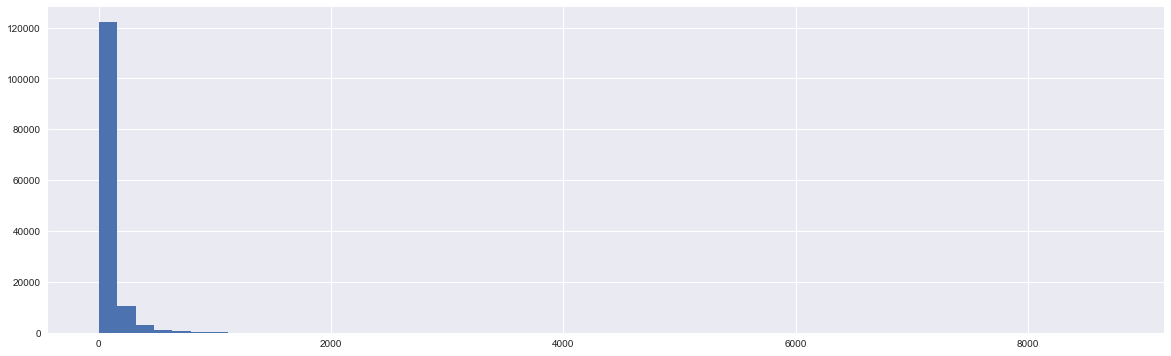

In [31]:
plt.figure(figsize=(20, 6))
df.favs.hist(bins=55)

In [ ]:
def hubs(df):
    hubs = {}
    for i in range(len(df)):
        for j in range(len(df['hubs'].iloc[i])):
            if df['hubs'].iloc[i][j]['title'] not in hubs:
                hubs[df['hubs'].iloc[i][j]['title']] = [0] * len(df)
            hubs[df['hubs'].iloc[i][j]['title']][i] = 1
    for hub in hubs:
        df[hub] = hubs[hub]

In [ ]:
hubs(df)

In [ ]:
def enc_flags(df):
    flags = {}
    for i in range(len(df)):
        #f = json.loads(df['flags'].iloc[i].replace("'", '\"'))
        f = df['flags'].iloc[i]
        for flag in f:
            if flag not in flags:
                flags[flag] = [0] * len(df)
            flags[flag][i] = 1

    for flag in flags:
        df['flag_' + flag] = flags[flag]

In [ ]:
enc_flags(df)

In [ ]:
df = pd.get_dummies(df, columns=["domain", "flow"])

In [ ]:
df = df.drop(['hubs', 'flags'], axis=1)

In [ ]:
from itertools import chain
from collections import Counter

#assemble all the tags
tags = list(map(lambda ch: {str(tag):1 for tag in ch}, df.tags))

#get most popular tags
tag_counts = Counter()
for tags_i in tags:
    tag_counts.update(tags_i.keys())

popular_tags = set(list(zip(*tag_counts.most_common(4096)))[0])

In [ ]:
for t in tqdm(popular_tags):
    col = []
    for ts in df.tags:
        if t in ts:
            col.append(1)
        else:
            col.append(0)
    df[t] = col

In [ ]:
from sklearn.feature_extraction import DictVectorizer
tag_vectorizer = DictVectorizer(sparse=False,dtype=np.float32).fit(tags)

tags_ix = tag_vectorizer.transform(tags)

In [ ]:
plt.figure(figsize=(20,8))
plt.hist(tags_ix.sum(1),bins=40)
plt.title("Number of tags per post")
plt.xlabel("Value")
plt.ylabel("Frequency")

In [ ]:
description = []
for i in tqdm(range(len(df))):
    try:
        description.append(df.meta_tags[i]["description"])
    except:
        print(i)
        description.append("Empty")
        pass
df["description"] = description

In [ ]:
df = df.drop("meta_tags", axis=1)

In [ ]:
df.columns

In [ ]:
df = df.drop(["quality", "tags"], axis = 1)

In [ ]:
import pymystem3
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

wordnet_lemmatizer = WordNetLemmatizer()
p = pymystem3.mystem.Mystem()

def post_to_wordlist(raw_text, remove_stopwords=False, normal=True):
    if normal:
        words = p.lemmatize(raw_text)
        words = [wordnet_lemmatizer.lemmatize(word) for word in words]
    else:
        words = nltk.word_tokenize(raw_text.lower())
    
    #pattern = re.compile(r'([a-zа-я0-9@$*\'\+\(\)\[\]]+\-@#)*[a-zа-я0-9@$*\'\+@#\(\)\[\]]+')
    #words = [w for w in words if pattern.match(w)]
    
    if remove_stopwords:
        stops = set(stopwords.words('russian')) | set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
    
    return words

In [ ]:
wordlist_title = df['title'].apply(lambda x: ' '.join(post_to_wordlist(x, remove_stopwords=True, normal=True)))
wordlist_description = df['description'].apply(lambda x: ' '.join(post_to_wordlist(x, remove_stopwords=True, normal=True)))

In [ ]:
df["wordlist_title"] = wordlist_title
df["wordlist_description"] = wordlist_description

In [ ]:
target_columns = ["favs_lognorm", "views_lognorm", "votes_plus", "votes_minus"]
targets = df[target_columns].values.astype('float32')

In [ ]:
df.columns

In [ ]:
df = df.drop(["title", "content", "description", 'favs_lognorm', "published", 'views_lognorm', 'votes_plus', 'votes_minus'], axis=1)

In [ ]:
train_words = wordlist_title[:134137]
train_words = train_words.append(wordlist_description[:134137], ignore_index=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

t = TfidfVectorizer()
t.fit(train_words)
tftitle_train = t.transform(wordlist_title[:134137])
tftitle_test = t.transform(wordlist_title[134137:])
tfdescr_train = t.transform(wordlist_description[:134137])
tfdescr_test = t.transform(wordlist_description[134137:])

In [ ]:
import scipy

train = scipy.sparse.hstack((tftitle_train, tfdescr_train))
test = scipy.sparse.hstack((tftitle_test, tfdescr_test))

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

train = train.tocsc()

R = Ridge(alpha=3, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

R.fit(train[50000:], targets[50000:134137, 0])
prediction = R.predict(test)

In [ ]:
pr_train = R.predict(train)

In [ ]:
df["prediction"] = np.concatenate((pr_train, prediction))

In [ ]:
XGBR = xgb.XGBRegressor(max_depth=10, n_estimators=20, silent=False)
XGBR.fit(df.iloc[50000:134137], targets[50000:134137, 0])
prediction = XGBR.predict(df.iloc[134137:])
print(mean_squared_error(targets[134137:, 0], prediction))
print(mean_absolute_error(targets[134137:, 0], prediction))
print(r2_score(targets[134137:, 0], prediction))

In [ ]:
model = Ridge(alpha=14, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

model.fit(tmp[50000:], targets[50000:134137, 1])
prediction = model.predict(test)
print(mean_squared_error(targets[134137:, 1], prediction))
print(mean_absolute_error(targets[134137:, 1], prediction))
print(r2_score(targets[134137:, 1], prediction))

In [53]:
from sklearn.model_selection import GridSearchCV

CV = GridSearchCV(
    Ridge(),
    {'alpha': np.arange(3, 20, 1)},
    scoring='neg_mean_squared_error',
    n_jobs=8,
    verbose=1
)
CV.fit(train[50000:], targets[50000:134137, 1])
print(CV.best_estimator_)
prediction = CV.predict(test)
print(mean_squared_error(targets[134137:, 1], prediction))
print(mean_absolute_error(targets[134137:, 1], prediction))
print(r2_score(targets[134137:, 1], prediction))

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.4s
[Parallel(n_jobs=8)]: Done  51 out of  51 | elapsed:   40.6s finished


Ridge(alpha=6, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
0.842039105296
0.697634270487
0.211462374098


In [55]:
pr_train = CV.predict(train)
df["prediction"] = np.concatenate((pr_train, prediction))

In [56]:
XGBR = xgb.XGBRegressor(max_depth=10, n_estimators=15, silent=False)
XGBR.fit(df.iloc[50000:134137], targets[50000:134137, 1])
prediction = XGBR.predict(df.iloc[134137:])
print(mean_squared_error(targets[134137:, 1], prediction))
print(mean_absolute_error(targets[134137:, 1], prediction))
print(r2_score(targets[134137:, 1], prediction))

0.878785
0.711019
0.177051650872


In [47]:
from sklearn.model_selection import GridSearchCV

CV = GridSearchCV(
    Ridge(),
    {'alpha': np.arange(3, 20, 1)},
    scoring='neg_mean_squared_error',
    n_jobs=8,
    verbose=2
)
CV.fit(train[50000:], targets[50000:134137, 2])
print(CV.best_estimator_)
prediction = CV.predict(test)
print(mean_squared_error(targets[134137:, 2], prediction))
print(mean_absolute_error(targets[134137:, 2], prediction))
print(r2_score(targets[134137:, 2], prediction))

Fitting 3 folds for each of 17 candidates, totalling 51 fits
[CV] alpha=3 .........................................................
[CV] alpha=3 .........................................................
[CV] alpha=3 .........................................................
[CV] alpha=4 .........................................................
[CV] alpha=4 .........................................................
[CV] alpha=4 .........................................................
[CV] alpha=5 .........................................................
[CV] alpha=5 .........................................................
[CV] .......................................... alpha=4, total=   7.2s
[CV] alpha=5 .........................................................
[CV] .......................................... alpha=5, total=   6.8s
[CV] alpha=6 .........................................................
[CV] .......................................... alpha=4, total=   7.4s
[CV] ...........

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   27.1s


[CV] ......................................... alpha=11, total=   6.2s
[CV] alpha=14 ........................................................
[CV] ......................................... alpha=11, total=   6.4s
[CV] alpha=14 ........................................................
[CV] ......................................... alpha=13, total=   5.8s
[CV] ......................................... alpha=12, total=   6.2s
[CV] alpha=15 ........................................................
[CV] alpha=15 ........................................................
[CV] ......................................... alpha=12, total=   6.5s
[CV] alpha=15 ........................................................
[CV] ......................................... alpha=13, total=   6.3s
[CV] alpha=16 ........................................................
[CV] ......................................... alpha=13, total=   5.6s
[CV] alpha=16 ........................................................
[CV] .

[Parallel(n_jobs=8)]: Done  51 out of  51 | elapsed:   41.7s finished


Ridge(alpha=7, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
0.341583153046
0.450995198648
0.183598523898


In [48]:
pr_train = CV.predict(train)
df["prediction"] = np.concatenate((pr_train, prediction))

In [49]:
%%time
XGBR = xgb.XGBRegressor(max_depth=10, n_estimators=15, silent=False)
XGBR.fit(df.iloc[50000:134137], targets[50000:134137, 2])
prediction = XGBR.predict(df.iloc[134137:])
print(mean_squared_error(targets[134137:, 2], prediction))
print(mean_absolute_error(targets[134137:, 2], prediction))
print(r2_score(targets[134137:, 2], prediction))

0.343379
0.451648
0.179305369386
CPU times: user 13min 4s, sys: 12min 12s, total: 25min 17s
Wall time: 31min 36s


In [50]:
from sklearn.model_selection import GridSearchCV

CV = GridSearchCV(
    Ridge(),
    {'alpha': np.arange(3, 20, 1)},
    scoring='neg_mean_squared_error',
    n_jobs=8,
    verbose=2
)
CV.fit(train[50000:], targets[50000:134137, 3])
print(CV.best_estimator_)
prediction = CV.predict(test)
print(mean_squared_error(targets[134137:, 3], prediction))
print(mean_absolute_error(targets[134137:, 3], prediction))
print(r2_score(targets[134137:, 3], prediction))

Fitting 3 folds for each of 17 candidates, totalling 51 fits
[CV] alpha=3 .........................................................
[CV] alpha=3 .........................................................
[CV] alpha=3 .........................................................
[CV] alpha=4 .........................................................
[CV] alpha=4 .........................................................
[CV] alpha=4 .........................................................
[CV] alpha=5 .........................................................
[CV] alpha=5 .........................................................
[CV] .......................................... alpha=3, total=   8.1s
[CV] alpha=5 .........................................................
[CV] .......................................... alpha=4, total=   8.2s
[CV] .......................................... alpha=4, total=   7.9s
[CV] alpha=6 .........................................................
[CV] alpha=6 ...

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   28.9s


[CV] ......................................... alpha=11, total=   6.3s
[CV] alpha=14 ........................................................
[CV] ......................................... alpha=13, total=   5.3s
[CV] alpha=14 ........................................................
[CV] ......................................... alpha=11, total=   6.1s
[CV] alpha=15 ........................................................
[CV] ......................................... alpha=12, total=   5.7s
[CV] alpha=15 ........................................................
[CV] ......................................... alpha=12, total=   6.3s
[CV] alpha=15 ........................................................
[CV] ......................................... alpha=13, total=   6.2s
[CV] alpha=16 ........................................................
[CV] ......................................... alpha=15, total=   5.5s
[CV] alpha=16 ........................................................
[CV] .

[Parallel(n_jobs=8)]: Done  51 out of  51 | elapsed:   45.0s finished


Ridge(alpha=6, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
0.67867649014
0.662809634725
0.0878976879745


In [51]:
pr_train = CV.predict(train)
df["prediction"] = np.concatenate((pr_train, prediction))

In [52]:
XGBR = xgb.XGBRegressor(max_depth=10, n_estimators=15, silent=False)
XGBR.fit(df.iloc[50000:134137], targets[50000:134137, 3])
prediction = XGBR.predict(df.iloc[134137:])
print(mean_squared_error(targets[134137:, 3], prediction))
print(mean_absolute_error(targets[134137:, 3], prediction))
print(r2_score(targets[134137:, 3], prediction))

0.775519
0.71193
-0.0422525359916


In [ ]:
import pickle

with open("tfidf_best_train.pcl", "rb") as f:
   t = pickle.load(f)

In [ ]:
df = df.drop("Unnamed: 0", axis=1)

In [ ]:
import scipy

train = a
test = b
for c in tqdm(df.columns):
    if c != 'wordlist_title' and c != 'wordlist_description':
        train = scipy.sparse.hstack((train, df[c][:134137,None]))
        test = scipy.sparse.hstack((test, df[c][134137:,None]))

In [ ]:
train

In [ ]:
import scipy

train = scipy.sparse.hstack((a, da))
test = scipy.sparse.hstack((b, db))

In [ ]:
import pickle

with open("sparse_train_test_w_descr.pcl", "wb") as f:
    pickle.dump([train, test], f)

In [ ]:
import pickle

with open("sparce_train_test.pcl", "wb") as f:
    pickle.dump([train, test], f)

In [ ]:
import pickle

with open("sparce_train_test.pcl", "rb") as f:
    train, test = pickle.load(f)

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

LR = Ridge(10)
LR.fit(train, targets[:134137, 0])
print(mean_squared_error(LR.predict(test), targets[134137:, 0]))

In [ ]:
coord_x = []
coord_y = []

In [ ]:
tmp = train.tocsc()

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

coord_x = []
r2 = []
mse = []
mae = []

for lower in tqdm(range(17000, 130000, 3000)):
    LR = Ridge(1)
    LR.fit(tmp[lower:], targets[lower:134137, 0])
    prediction = LR.predict(test)
    coord_x.append(lower)
    r2.append(r2_score(targets[134137:, 0], prediction))
    mse.append(mean_squared_error(targets[134137:, 0], prediction))
    mae.append(mean_absolute_error(targets[134137:, 0], prediction))

In [ ]:
for i in range(len(coord_x)):
    coord_x[i] = 134000 - coord_x[i]

In [ ]:
plt.figure(figsize=(20,8))
plt.title("R^2 per train size")
plt.xlabel("Train Size")
plt.ylabel("Error")
plt.plot(coord_x, r2)
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.title("R^2 per train size")
plt.xlabel("Train Size")
plt.ylabel("Error")
plt.plot(coord_x, r2)
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.title("MSE per train size")
plt.xlabel("Train Size")
plt.ylabel("Error")
plt.plot(coord_x, mse)
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.title("MSE per train size")
plt.xlabel("Train Size")
plt.ylabel("Error")
plt.plot(coord_x, mse)
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.title("MAE per train size")
plt.xlabel("Train Size")
plt.ylabel("Error")
plt.plot(coord_x, mae)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

CV = GridSearchCV(
    Ridge(),
    {'alpha': np.arange(3, 20, 1)},
    scoring='neg_mean_squared_error',
    n_jobs=8,
    verbose=2
)
CV.fit(tmp[50000:], targets[50000:134137, 0])

In [ ]:
prediction = CV.predict(test)
print(mean_squared_error(targets[134137:, 0], prediction))
print(mean_absolute_error(targets[134137:, 0], prediction))
print(r2_score(targets[134137:, 0], prediction))

In [ ]:
print(mean_squared_error(CV.predict(test), targets[134137:, 0]))

In [ ]:
CV.best_estimator_

In [ ]:
from sklearn.model_selection import GridSearchCV

CV = GridSearchCV(
    Ridge(),
    {'alpha': np.arange(15, 25, 3)},
    scoring='neg_mean_squared_error',
    n_jobs=6,
    verbose=2
)
CV.fit(tmp[50000:], targets[50000:134137, 1])

In [ ]:
model = Ridge(alpha=14, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

model.fit(tmp[50000:], targets[50000:134137, 1])
prediction = model.predict(test)
print(mean_squared_error(targets[134137:, 1], prediction))
print(mean_absolute_error(targets[134137:, 1], prediction))
print(r2_score(targets[134137:, 1], prediction))

In [ ]:
print(mean_squared_error(CV.predict(test), targets[134137:, 1]))

In [ ]:
CV.best_estimator_

In [ ]:
import xgboost as xgb

XGBR = xgb.XGBRegressor(max_depth=10, n_estimators=1000, silent=False)
XGBR.fit(train, targets[50000:134137, 0])
print(mean_squared_error(XGBR.predict(test), targets[134137:, 0]))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

CV = GridSearchCV(
    RandomForestRegressor(n_estimators = 7),
    {"max_depth": np.arange(13, 22, 2)},
    scoring='neg_mean_squared_error',
    n_jobs=8,
    verbose=2
)
CV.fit(tmp[50000:], targets[50000:134137, 0])

In [ ]:
print(mean_squared_error(CV.predict(test), targets[134137:, 0]))

In [ ]:
CV.best_estimator_

In [ ]:
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=7, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

model.fit(tmp[50000:], targets[50000:134137, 0])
prediction = model.predict(test)
print(mean_squared_error(targets[134137:, 0], prediction))
print(mean_absolute_error(targets[134137:, 0], prediction))
print(r2_score(targets[134137:, 0], prediction))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

CV = GridSearchCV(
    RandomForestRegressor(max_depth=21),
    {"n_estimators": np.arange(5, 10, 1)},
    scoring='neg_mean_squared_error',
    n_jobs=8,
    verbose=2
)
CV.fit(tmp[50000:], targets[50000:134137, 1])

In [ ]:
CV.best_estimator_

In [ ]:
prediction = CV.predict(test)
print(r2_score(targets[134137:, 1], prediction))
mean_squared_error(targets[134137:, 1], prediction)
mean_absolute_error(targets[134137:, 1], prediction)

In [ ]:
r2_score(targets[134137:, 1], prediction)

In [ ]:
mean_squared_error(targets[134137:, 1], prediction)

In [ ]:
from sklearn.model_selection import GridSearchCV

CV = GridSearchCV(
    Ridge(),
    {'alpha': np.arange(3, 20, 1)},
    scoring='neg_mean_squared_error',
    n_jobs=8,
    verbose=2
)
CV.fit(tmp[50000:], targets[50000:134137, 2])
print(CV.best_estimator_)
prediction = CV.predict(test)
print(mean_squared_error(targets[134137:, 2], prediction))
print(mean_absolute_error(targets[134137:, 2], prediction))
print(r2_score(targets[134137:, 2], prediction))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

CV = GridSearchCV(
    RandomForestRegressor(max_depth=21),
    {"n_estimators": np.arange(9, 12, 1)},
    scoring='neg_mean_squared_error',
    n_jobs=8,
    verbose=2
)
CV.fit(tmp[50000:], targets[50000:134137, 2])
print(CV.best_estimator_)
prediction = CV.predict(test)
print(mean_squared_error(targets[134137:, 2], prediction))
print(mean_absolute_error(targets[134137:, 2], prediction))
print(r2_score(targets[134137:, 2], prediction))

In [ ]:
from sklearn.model_selection import GridSearchCV

CV = GridSearchCV(
    Ridge(),
    {'alpha': np.arange(3, 20, 1)},
    scoring='neg_mean_squared_error',
    n_jobs=8,
    verbose=2
)
CV.fit(tmp[50000:], targets[50000:134137, 3])
print(CV.best_estimator_)
prediction = CV.predict(test)
print(mean_squared_error(targets[134137:, 3], prediction))
print(mean_absolute_error(targets[134137:, 3], prediction))
print(r2_score(targets[134137:, 3], prediction))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

CV = GridSearchCV(
    RandomForestRegressor(max_depth=21),
    {"n_estimators": np.arange(7, 12, 1)},
    scoring='neg_mean_squared_error',
    n_jobs=8,
    verbose=2
)
CV.fit(tmp[50000:], targets[50000:134137, 3])
print(CV.best_estimator_)
prediction = CV.predict(test)
print(mean_squared_error(targets[134137:, 3], prediction))
print(mean_absolute_error(targets[134137:, 3], prediction))
print(r2_score(targets[134137:, 3], prediction))

In [ ]:
df.columns